# 📊 Modèles prédictifs pour les incidents de cybersécurité

Ce carnet présente le développement de deux modèles prédictifs appliqués aux incidents de cybersécurité :

  1.Un modèle de prédiction du temps de réparation des incidents

  2.Un modèle de prédiction du temps de résolution des incidents

La démarche suivie est fondée sur une méthodologie intégrale, comportant :

  -Une analyse exploratoire des données (EDA)

  -Le nettoyage et le prétraitement de données

  -L’ingénierie et la sélection de caractéristiques pertinentes

  -La conception, l’évaluation et la comparaison de plusieurs modèles

  -L’optimisation des performances par la recherche d’hyperparamètres

## 1. Importation des bibliothèques nécessaires

In [2]:
# Bibliothèques de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Bibliothèques pour le prétraitement
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# Bibliothèques pour la sélection de caractéristiques
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.decomposition import PCA

# Bibliothèques pour les modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Bibliothèques pour l'évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Configuration pour les visualisations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

# Pour ignorer les avertissements
import warnings
warnings.filterwarnings('ignore')

## 2. Chargement et exploration des données

In [3]:
# Chargement du jeu de données
df = pd.read_csv('../Donnees_Collecter/kaggle_data.csv')

# Affichage des premières lignes
print("Aperçu des données :")
df.head()

Aperçu des données :


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


In [183]:
# Informations sur le jeu de données
print("\nInformations sur le jeu de données :")
df.info()


Informations sur le jeu de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 234.5+ KB

In [184]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
df.describe().T


Statistiques descriptives :


,count,mean,std,min,25%,50%,75%,max
Year,3000.0,2019.570333,2.857932,2015.0,2017.0000,2020.000,2022.00,2024.00
Financial Loss (in Million $),3000.0,50.492970,28.791415,0.5,25.7575,50.795,75.63,99.99
Number of Affected Users,3000.0,504684.136333,289944.084972,424.0,255805.2500,504513.000,758088.50,999635.00
Incident Resolution Time (in Hours),3000.0,36.476000,20.570768,1.0,19.0000,37.000,55.00,72.00


In [185]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Nombre de valeurs manquantes': missing_values, 
                          'Pourcentage (%)': missing_percentage})
missing_df


Valeurs manquantes par colonne :


,Nombre de valeurs manquantes,Pourcentage (%)
Country,0,0.0
Year,0,0.0
Attack Type,0,0.0
Target Industry,0,0.0
Financial Loss (in Million $),0,0.0
Number of Affected Users,0,0.0
Attack Source,0,0.0
Security Vulnerability Type,0,0.0
Defense Mechanism Used,0,0.0
Incident Resolution Time (in Hours),0,0.0


In [186]:
# Analyse des variables catégorielles
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nVariables catégorielles :")
for col in categorical_columns:
    print(f"\n{col} - {df[col].nunique()} valeurs uniques:")
    print(df[col].value_counts().sort_values(ascending=False).head(10))


Variables catégorielles :

Country - 10 valeurs uniques:
Country
UK           321
Brazil       310
India        308
Japan        305
France       305
Australia    297
Russia       295
Germany      291
USA          287
China        281
Name: count, dtype: int64

Attack Type - 6 valeurs uniques:
Attack Type
DDoS                 531
Phishing             529
SQL Injection        503
Ransomware           493
Malware              485
Man-in-the-Middle    459
Name: count, dtype: int64

Target Industry - 7 valeurs uniques:
Target Industry
IT                    478
Banking               445
Healthcare            429
Retail                423
Education             419
Government            403
Telecommunications    403
Name: count, dtype: int64

Attack Source - 4 valeurs uniques:
Attack Source
Nation-state    794
Unknown         768
Insider         752
Hacker Group    686
Name: count, dtype: int64

Security Vulnerability Type - 4 valeurs uniques:
Security Vulnerability Type
Zero-day            

### 2.1 Visualisation des distributions

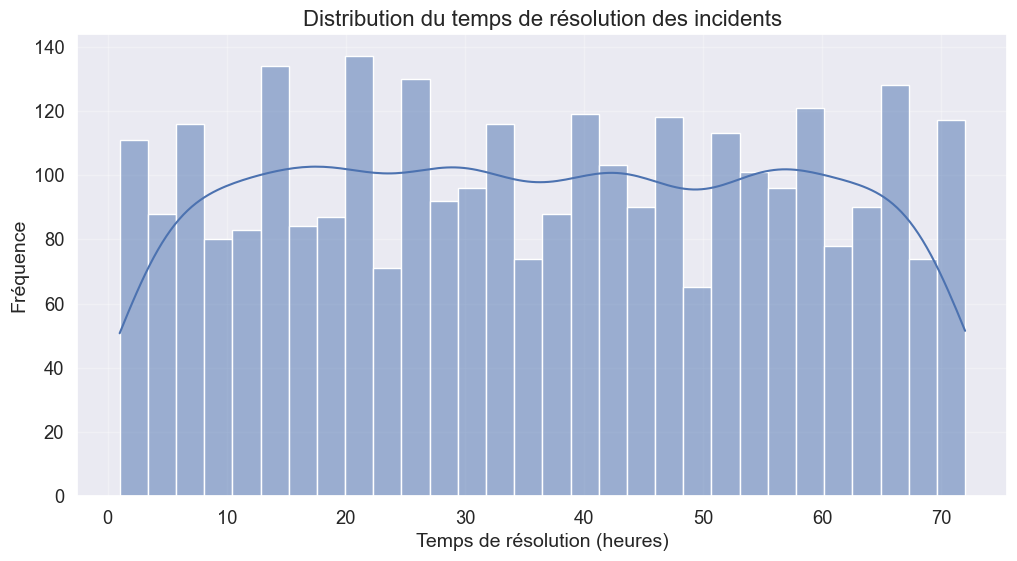

In [187]:
# Distribution de la variable cible (temps de résolution)
plt.figure(figsize=(12, 6))
sns.histplot(df['Incident Resolution Time (in Hours)'], kde=True, bins=30)
plt.title('Distribution du temps de résolution des incidents')
plt.xlabel('Temps de résolution (heures)')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)
plt.show()

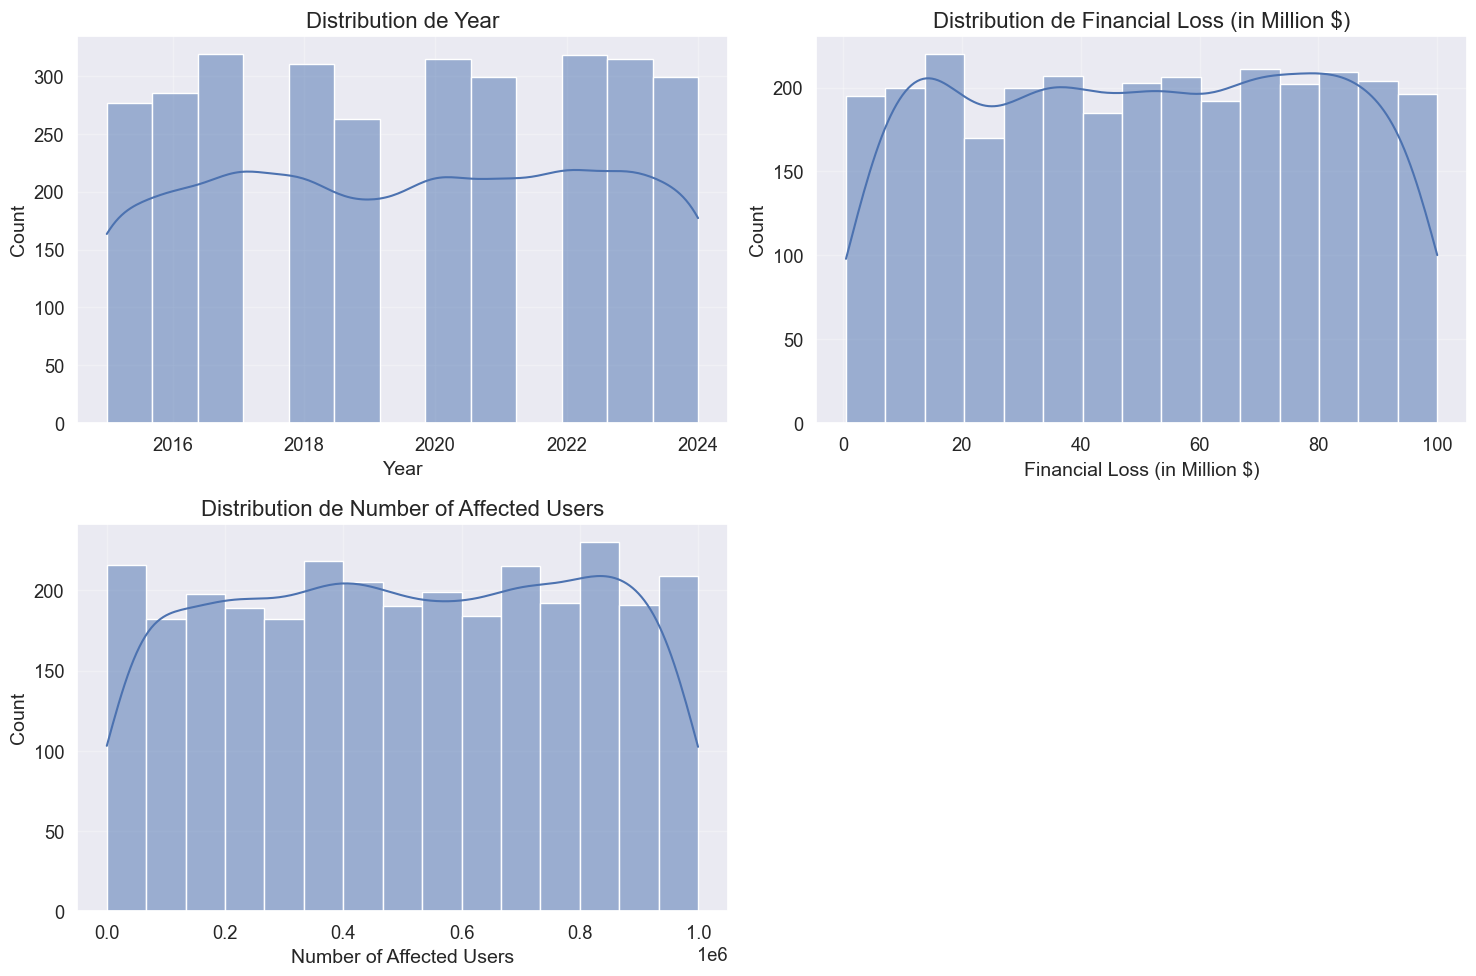

In [188]:
# Visualisation des variables numériques
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'Incident Resolution Time (in Hours)']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution de {col}')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

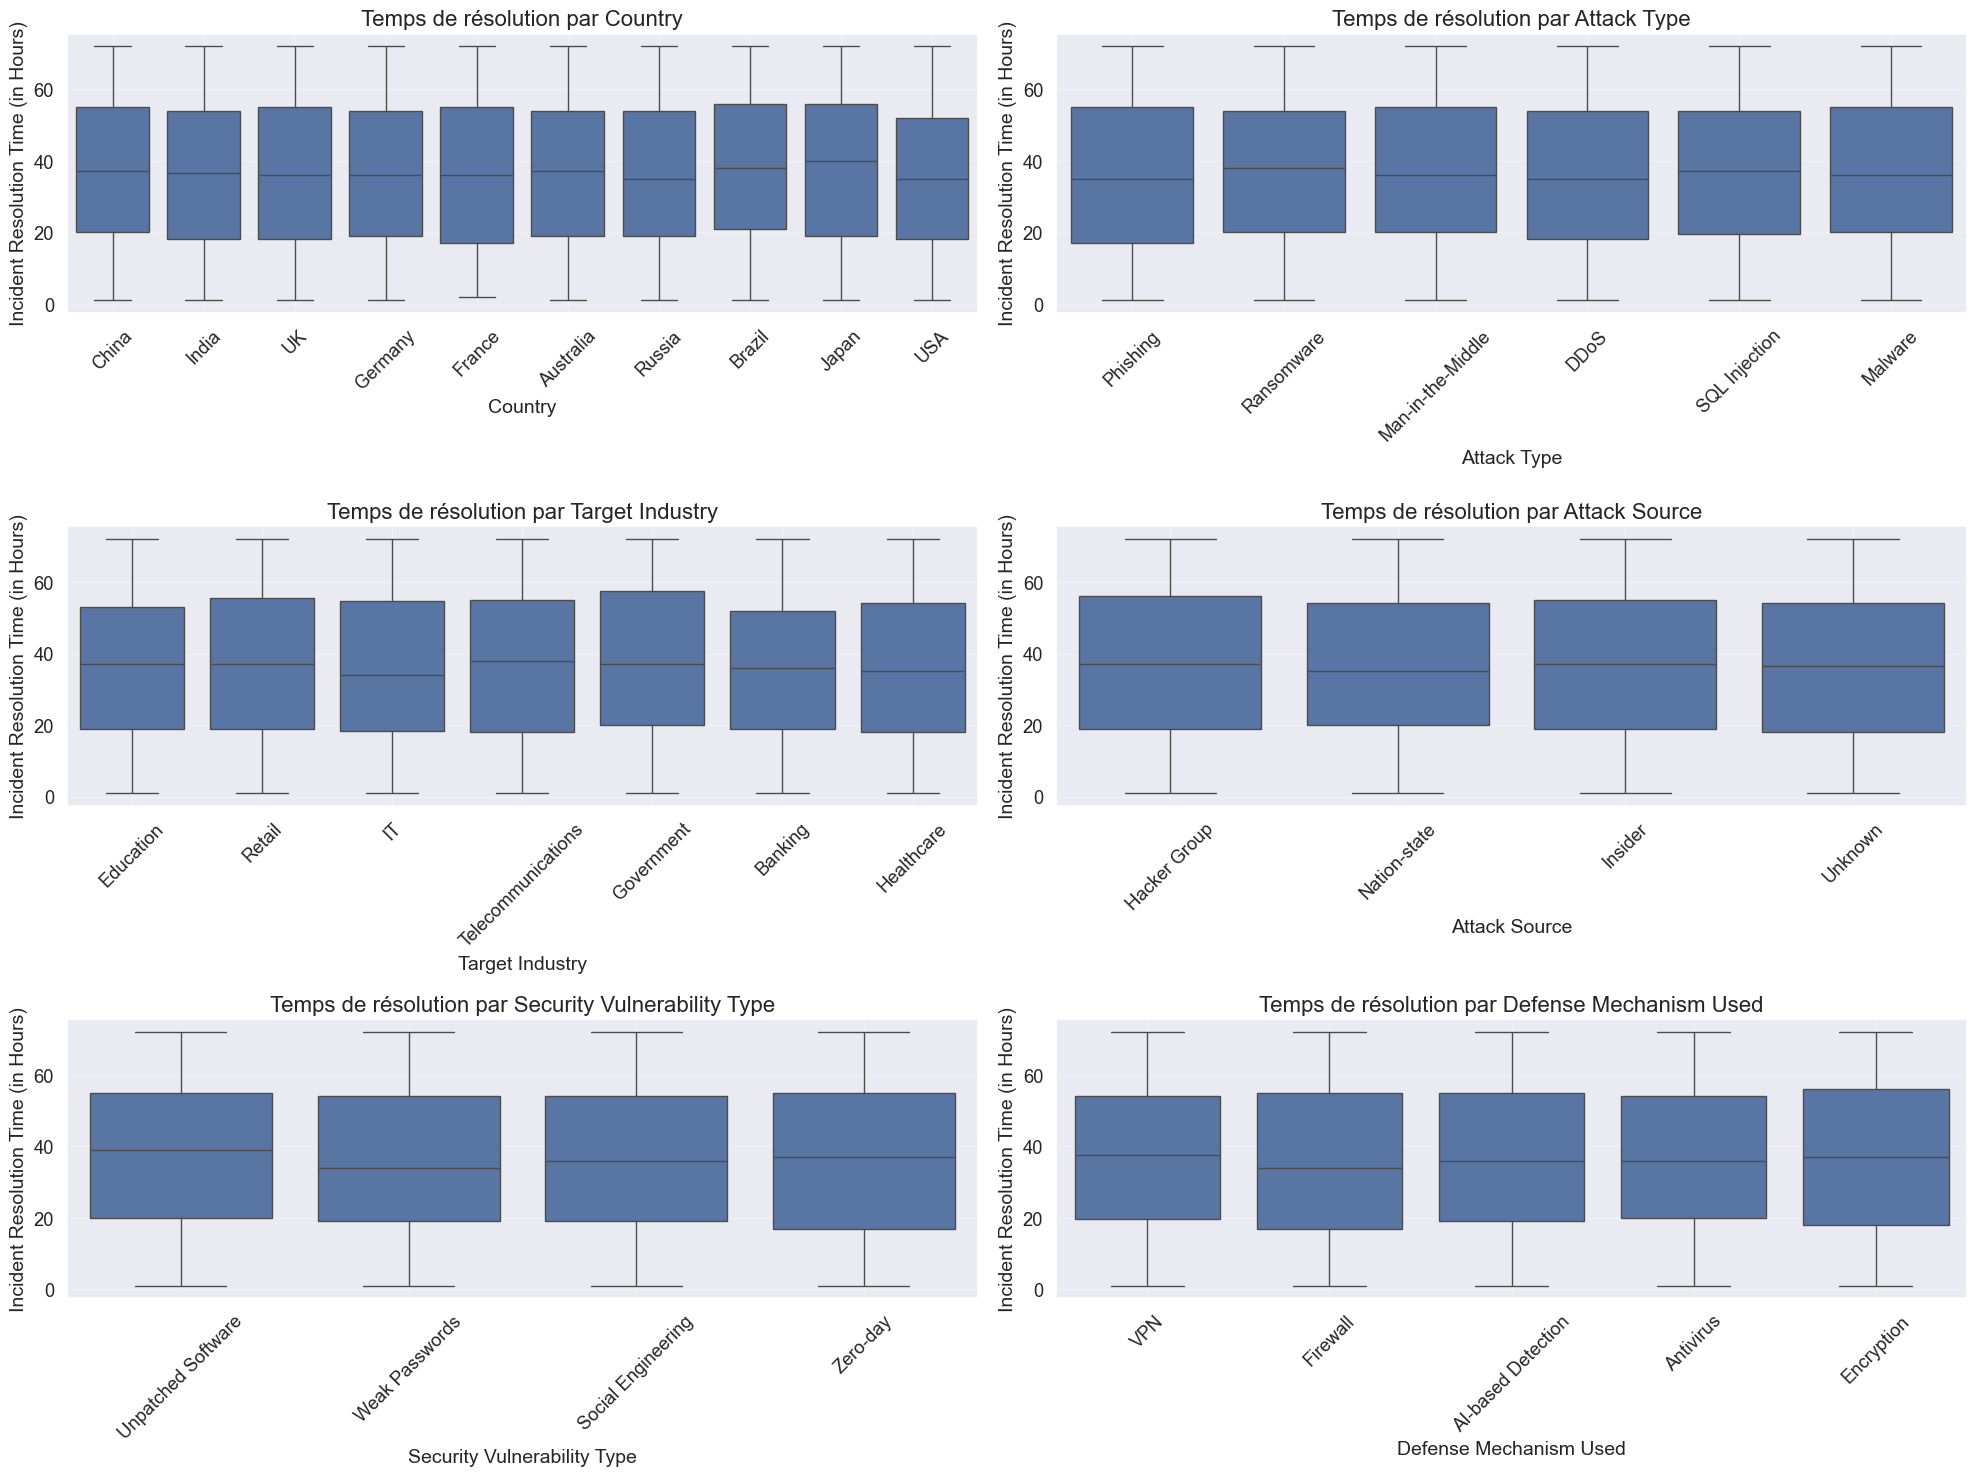

In [189]:
# Visualisation des variables catégorielles par rapport au temps de résolution
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_columns[:6], 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=col, y='Incident Resolution Time (in Hours)', data=df)
    plt.title(f'Temps de résolution par {col}')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [190]:
# Visualisation des variables catégorielles restantes par rapport au temps de résolution
remaining_cat_cols = categorical_columns[6:]
if len(remaining_cat_cols) > 0:
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(remaining_cat_cols, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x=col, y='Incident Resolution Time (in Hours)', data=df)
        plt.title(f'Temps de résolution par {col}')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### 2.2 Analyse des corrélations

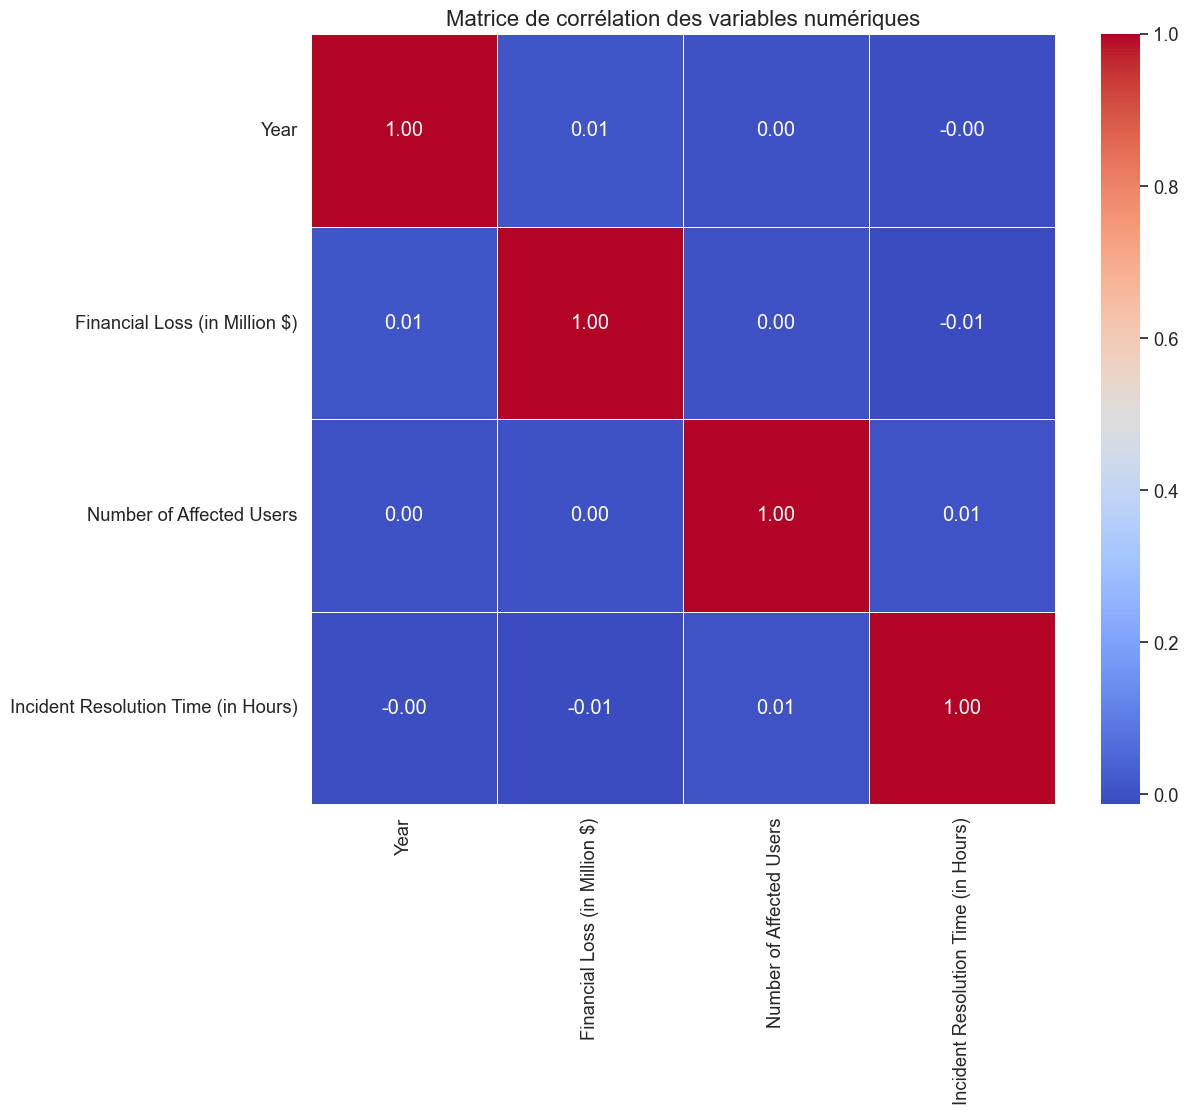

In [191]:
# Matrice de corrélation pour les variables numériques
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des variables numériques')
plt.show()

ValueError: num must be an integer with 1 <= num <= 2, not 3

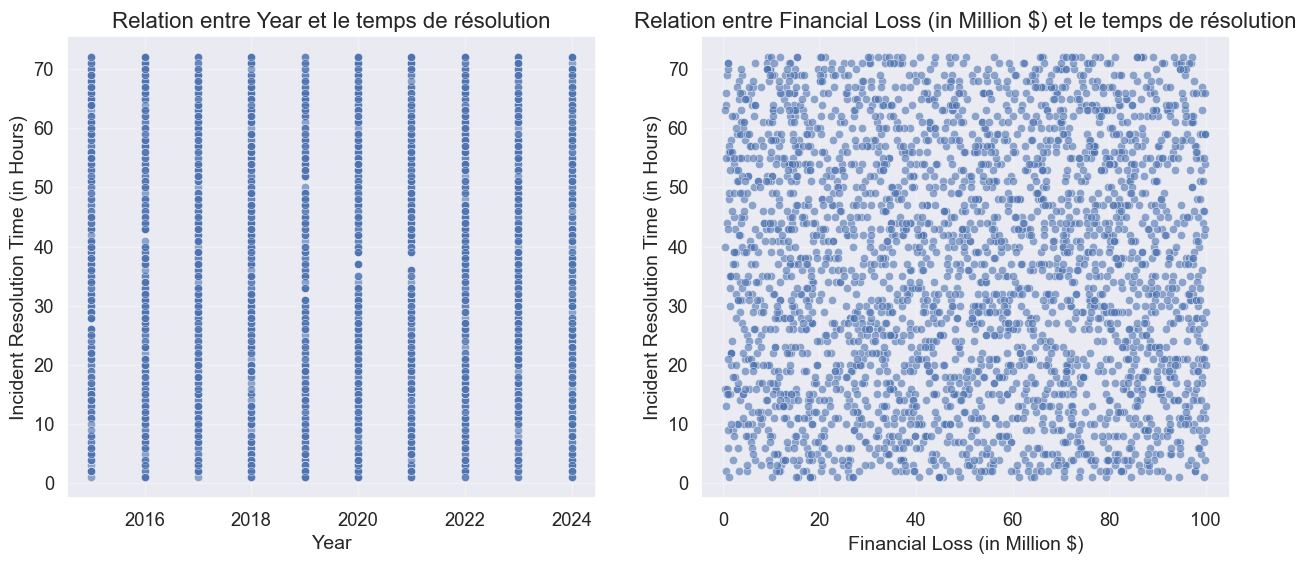

In [192]:
# Analyse de la relation entre les variables numériques et le temps de résolution
plt.figure(figsize=(15, 6))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 2, i)
    sns.scatterplot(x=col, y='Incident Resolution Time (in Hours)', data=df, alpha=0.6)
    plt.title(f'Relation entre {col} et le temps de résolution')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Prétraitement des données

In [ ]:
# Création d'une copie du dataframe pour le prétraitement
df_processed = df.copy()

# Vérification des doublons
print(f"Nombre de doublons : {df_processed.duplicated().sum()}")
if df_processed.duplicated().sum() > 0:
    df_processed = df_processed.drop_duplicates()
    print(f"Doublons supprimés. Nouvelle taille du dataframe : {df_processed.shape}")

Nombre de doublons : 0


In [ ]:
# Création de nouvelles caractéristiques

# 1. Création d'une caractéristique pour l'âge de l'attaque (année actuelle - année de l'attaque)
current_year = datetime.now().year
df_processed['Attack_Age'] = current_year - df_processed['Year']

# 2. Ratio de perte financière par utilisateur affecté
df_processed['Loss_per_User'] = df_processed['Financial Loss (in Million $)'] * 1000000 / df_processed['Number of Affected Users']

# 3. Catégorisation des attaques par gravité basée sur la perte financière
df_processed['Attack_Severity'] = pd.qcut(df_processed['Financial Loss (in Million $)'], 4, 
                                         labels=['Low', 'Medium', 'High', 'Critical'])

# 4. Catégorisation des attaques par échelle basée sur le nombre d'utilisateurs affectés
df_processed['Attack_Scale'] = pd.qcut(df_processed['Number of Affected Users'], 4, 
                                      labels=['Small', 'Medium', 'Large', 'Massive'])

# 5. Combinaison de type d'attaque et source d'attaque
df_processed['Attack_Type_Source'] = df_processed['Attack Type'] + '_' + df_processed['Attack Source']

# 6. Combinaison de vulnérabilité et mécanisme de défense
df_processed['Vulnerability_Defense'] = df_processed['Security Vulnerability Type'] + '_' + df_processed['Defense Mechanism Used']

# Affichage des nouvelles caractéristiques
print("Aperçu des nouvelles caractéristiques :")
df_processed[['Attack_Age', 'Loss_per_User', 'Attack_Severity', 'Attack_Scale', 
              'Attack_Type_Source', 'Vulnerability_Defense']].head()

Aperçu des nouvelles caractéristiques :


,Attack_Age,Loss_per_User,Attack_Severity,Attack_Scale,Attack_Type_Source,Vulnerability_Defense
0,6,104.155754,Critical,Massive,Phishing_Hacker Group,Unpatched Software_VPN
1,6,210.129037,High,Medium,Ransomware_Hacker Group,Unpatched Software_Firewall
2,8,63.789931,Medium,Large,Man-in-the-Middle_Hacker Group,Weak Passwords_VPN
3,1,62.852636,Medium,Large,Ransomware_Nation-state,Social Engineering_AI-based Detection
4,7,91.786915,High,Massive,Man-in-the-Middle_Insider,Social Engineering_VPN


In [ ]:
# Définition des variables catégorielles et numériques pour le prétraitement
categorical_features = ['Country', 'Attack Type', 'Target Industry', 'Attack Source', 
                        'Security Vulnerability Type', 'Defense Mechanism Used',
                        'Attack_Severity', 'Attack_Scale', 'Attack_Type_Source', 'Vulnerability_Defense']

numerical_features = ['Year', 'Financial Loss (in Million $)', 'Number of Affected Users', 
                      'Attack_Age', 'Loss_per_User']

# Définition de la variable cible
target = 'Incident Resolution Time (in Hours)'

In [ ]:
# Séparation des caractéristiques et de la cible
X = df_processed[categorical_features + numerical_features]
y = df_processed[target]

# Division en ensembles d'entraînement et de test (80% entraînement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille de l'ensemble d'entraînement : {X_train.shape}")
print(f"Taille de l'ensemble de test : {X_test.shape}")

Taille de l'ensemble d'entraînement : (2400, 15)
Taille de l'ensemble de test : (600, 15)


In [ ]:
# Création d'un pipeline de prétraitement
# Pour les variables catégorielles : encodage one-hot
# Pour les variables numériques : imputation des valeurs manquantes et standardisation

# Préprocesseur pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Préprocesseur pour les variables numériques
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combinaison des préprocesseurs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Application du prétraitement aux données d'entraînement
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Forme des données d'entraînement après prétraitement : {X_train_processed.shape}")
print(f"Forme des données de test après prétraitement : {X_test_processed.shape}")

Forme des données d'entraînement après prétraitement : (2400, 93)
Forme des données de test après prétraitement : (600, 93)


## 4. Sélection des caractéristiques

In [ ]:
# Utilisation de SelectKBest pour sélectionner les meilleures caractéristiques
k_best = min(30, X_train_processed.shape[1])  # Limiter à 30 caractéristiques ou moins si moins disponibles
selector = SelectKBest(score_func=f_regression, k=k_best)
X_train_selected = selector.fit_transform(X_train_processed, y_train)
X_test_selected = selector.transform(X_test_processed)

print(f"Nombre de caractéristiques sélectionnées : {X_train_selected.shape[1]}")

# Récupération des indices des caractéristiques sélectionnées
selected_indices = selector.get_support(indices=True)
print(f"Indices des caractéristiques sélectionnées : {selected_indices}")

Nombre de caractéristiques sélectionnées : 30
Indices des caractéristiques sélectionnées : [ 6 10 12 14 15 16 21 23 26 28 31 33 35 36 39 43 49 51 53 57 64 68 75 76
 78 79 83 85 86 89]


In [ ]:
# Utilisation de RFE avec Random Forest pour sélectionner les caractéristiques
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=min(20, X_train_processed.shape[1]), step=1)
X_train_rfe = rfe.fit_transform(X_train_processed, y_train)
X_test_rfe = rfe.transform(X_test_processed)

print(f"Nombre de caractéristiques sélectionnées par RFE : {X_train_rfe.shape[1]}")

# Récupération des indices des caractéristiques sélectionnées par RFE
rfe_selected_indices = np.where(rfe.support_)[0]
print(f"Indices des caractéristiques sélectionnées par RFE : {rfe_selected_indices}")

Nombre de caractéristiques sélectionnées par RFE : 20
Indices des caractéristiques sélectionnées par RFE : [ 0  1  2  3  4 15 18 19 24 25 27 28 30 31 32 34 35 38 39 40]


In [ ]:
# Comparaison des deux méthodes de sélection
common_features = np.intersect1d(selected_indices, rfe_selected_indices)
print(f"Nombre de caractéristiques communes entre SelectKBest et RFE : {len(common_features)}")
print(f"Indices des caractéristiques communes : {common_features}")

# Utilisation des caractéristiques sélectionnées par RFE pour la suite
X_train_final = X_train_rfe
X_test_final = X_test_rfe

Nombre de caractéristiques communes entre SelectKBest et RFE : 5
Indices des caractéristiques communes : [15 28 31 35 39]


## 5. Construction et évaluation des modèles pour le temps de résolution

In [ ]:
# Définition des modèles à tester
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

# Fonction pour évaluer un modèle
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métriques d'évaluation
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

# Évaluation de tous les modèles
results = {}
for name, model in models.items():
    print(f"Évaluation du modèle : {name}")
    try:
        results[name] = evaluate_model(model, X_train_final, X_test_final, y_train, y_test)
        print(f"  RMSE (test): {results[name]['test_rmse']:.2f}")
        print(f"  MAE (test): {results[name]['test_mae']:.2f}")
        print(f"  R² (test): {results[name]['test_r2']:.4f}")
    except Exception as e:
        print(f"  Erreur lors de l'évaluation du modèle {name}: {e}")

Évaluation du modèle : Linear Regression
  RMSE (test): 20.74
  MAE (test): 17.88
  R² (test): -0.0095
Évaluation du modèle : Ridge
  RMSE (test): 20.74
  MAE (test): 17.88
  R² (test): -0.0094
Évaluation du modèle : Lasso
  RMSE (test): 20.65
  MAE (test): 17.85
  R² (test): -0.0005
Évaluation du modèle : ElasticNet
  RMSE (test): 20.65
  MAE (test): 17.85
  R² (test): -0.0005
Évaluation du modèle : Decision Tree
  RMSE (test): 30.85
  MAE (test): 25.57
  R² (test): -1.2342
Évaluation du modèle : Random Forest
  RMSE (test): 21.33
  MAE (test): 18.41
  R² (test): -0.0683
Évaluation du modèle : Gradient Boosting
  RMSE (test): 21.02
  MAE (test): 18.05
  R² (test): -0.0373
Évaluation du modèle : XGBoost
  RMSE (test): 23.05
  MAE (test): 19.37
  R² (test): -0.2468
Évaluation du modèle : LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

In [ ]:
# Création d'un dataframe pour comparer les résultats
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE (Train)': [results[model]['train_rmse'] for model in results],
    'RMSE (Test)': [results[model]['test_rmse'] for model in results],
    'MAE (Train)': [results[model]['train_mae'] for model in results],
    'MAE (Test)': [results[model]['test_mae'] for model in results],
    'R² (Train)': [results[model]['train_r2'] for model in results],
    'R² (Test)': [results[model]['test_r2'] for model in results]
})

# Tri par RMSE de test (croissant)
results_df = results_df.sort_values('RMSE (Test)')
results_df

,Model,RMSE (Train),RMSE (Test),MAE (Train),MAE (Test),R² (Train),R² (Test)
3,ElasticNet,20.548015,20.645384,17.813068,17.845850,0.000000,-0.000452
2,Lasso,20.548015,20.645384,17.813068,17.845850,0.000000,-0.000452
1,Ridge,20.499372,20.737856,17.764805,17.883616,0.004729,-0.009434
0,Linear Regression,20.499371,20.738211,17.764720,17.883720,0.004729,-0.009469
9,SVR,20.330257,20.808718,17.469666,17.919863,0.021083,-0.016344
6,Gradient Boosting,18.900354,21.022178,16.207986,18.047905,0.153942,-0.037303
5,Random Forest,8.008187,21.334020,6.785867,18.411450,0.848110,-0.068306
8,LightGBM,14.955689,21.627454,12.704057,18.485945,0.470247,-0.097896
10,KNN,18.660235,22.429949,15.701250,18.729000,0.175303,-0.180883
7,XGBoost,6.803523,23.047632,5.232805,19.370113,0.890370,-0.246818


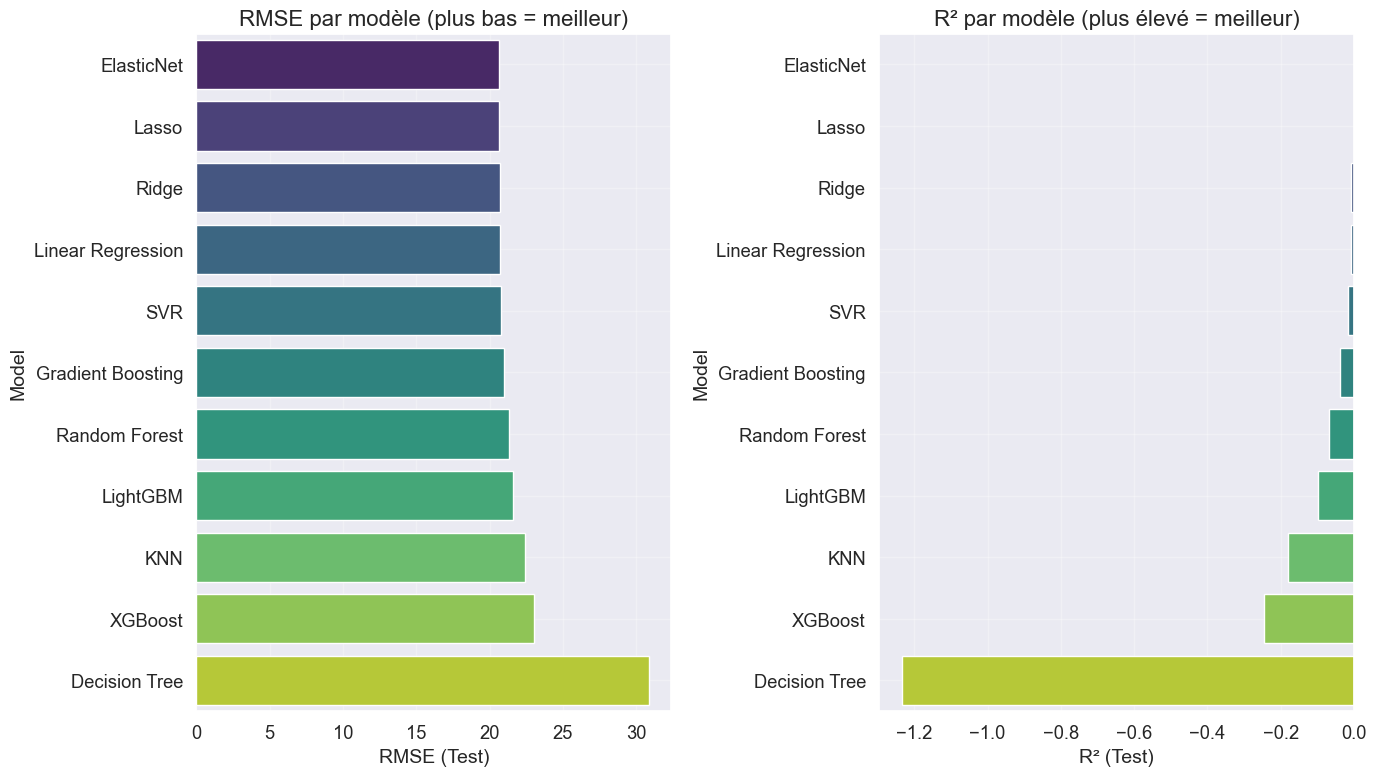

In [ ]:
# Visualisation des performances des modèles
plt.figure(figsize=(14, 8))

# RMSE
plt.subplot(1, 2, 1)
sns.barplot(x='RMSE (Test)', y='Model', data=results_df, palette='viridis')
plt.title('RMSE par modèle (plus bas = meilleur)')
plt.grid(True, alpha=0.3)

# R²
plt.subplot(1, 2, 2)
sns.barplot(x='R² (Test)', y='Model', data=results_df, palette='viridis')
plt.title('R² par modèle (plus élevé = meilleur)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.1 Optimisation du meilleur modèle pour le temps de résolution

In [ ]:
# Sélection des 3 meilleurs modèles basés sur le RMSE de test
top_models = results_df.head(3)['Model'].values
print(f"Les 3 meilleurs modèles sont : {top_models}")

# Sélection du meilleur modèle pour l'optimisation
best_model_name = top_models[0]
print(f"Le meilleur modèle est : {best_model_name}")

Les 3 meilleurs modèles sont : ['ElasticNet' 'Lasso' 'Ridge']
Le meilleur modèle est : ElasticNet


In [ ]:
# Définition des hyperparamètres à optimiser en fonction du meilleur modèle
if best_model_name == 'Random Forest':
    model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    model = GradientBoostingRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'XGBoost':
    model = XGBRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
elif best_model_name == 'LightGBM':
    model = LGBMRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 70]
    }
else:  # Modèle par défaut si aucun des précédents n'est le meilleur
    model = models[best_model_name]
    if best_model_name == 'SVR':
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.1, 0.01]
        }
    elif best_model_name == 'KNN':
        param_grid = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    else:  # Pour les modèles linéaires
     param_grid = {
        'fit_intercept': [True, False]
    }
    if 'normalize' in model.get_params():
        param_grid['normalize'] = [True, False]
    if best_model_name in ['Ridge', 'Lasso', 'ElasticNet']:
        param_grid['alpha'] = [0.001, 0.01, 0.1, 1, 10, 100]
    if best_model_name == 'ElasticNet':
        param_grid['l1_ratio'] = [0.1, 0.3, 0.5, 0.7, 0.9]


# Optimisation des hyperparamètres avec validation croisée
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_final, y_train)

# Meilleurs hyperparamètres
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score de validation croisée (RMSE) : {np.sqrt(-grid_search.best_score_):.2f}")

# Modèle optimisé
best_model_resolution = grid_search.best_estimator_

# Évaluation du modèle optimisé
y_train_pred = best_model_resolution.predict(X_train_final)
y_test_pred = best_model_resolution.predict(X_test_final)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nPerformances du modèle optimisé :")
print(f"RMSE (train) : {train_rmse:.2f}")
print(f"RMSE (test) : {test_rmse:.2f}")
print(f"R² (train) : {train_r2:.4f}")
print(f"R² (test) : {test_r2:.4f}")

Meilleurs hyperparamètres : {'alpha': 1, 'fit_intercept': True, 'l1_ratio': 0.7}
Meilleur score de validation croisée (RMSE) : 20.55

Performances du modèle optimisé :
RMSE (train) : 20.55
RMSE (test) : 20.65
R² (train) : 0.0000
R² (test) : -0.0005


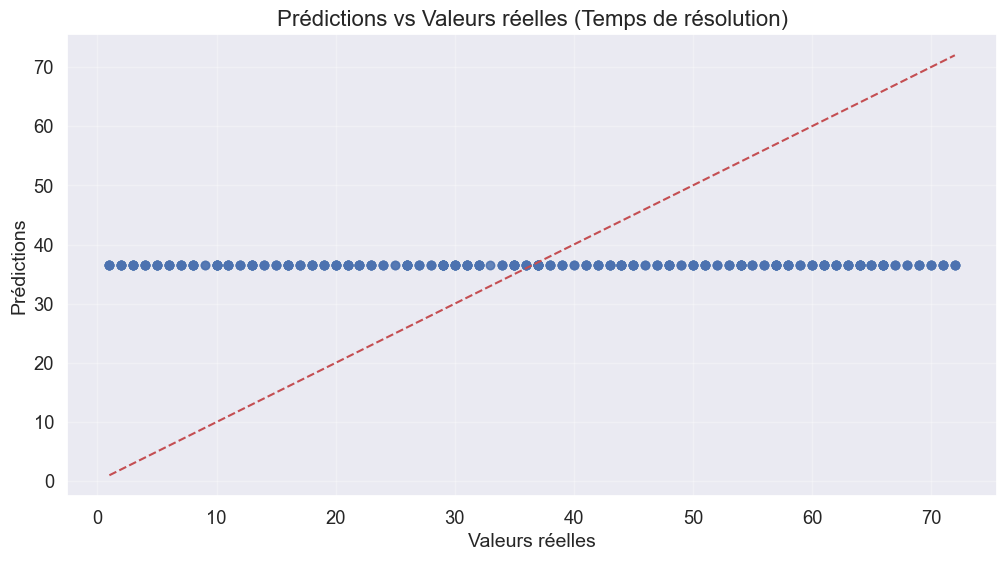

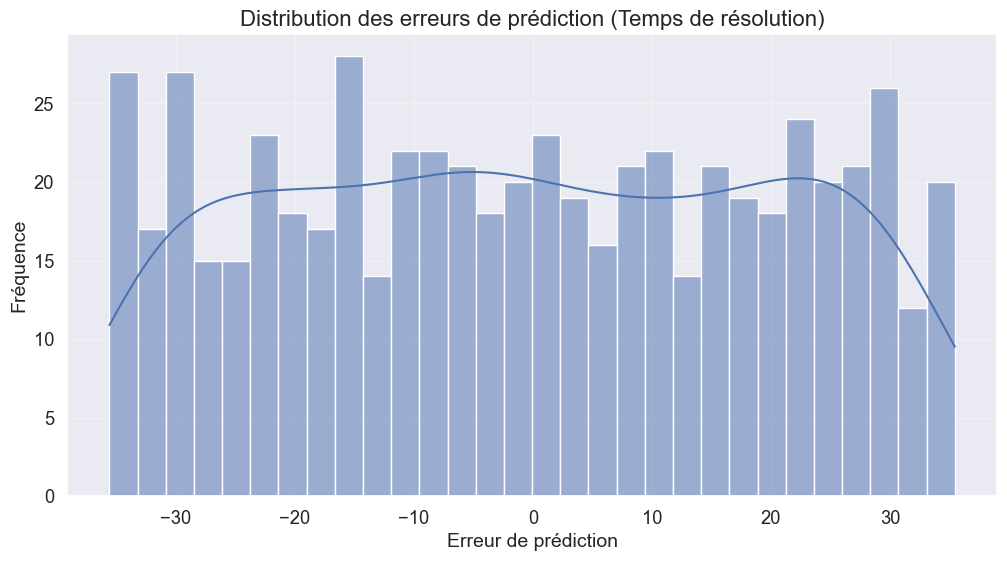

In [ ]:
# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles (Temps de résolution)')
plt.grid(True, alpha=0.3)
plt.show()

# Histogramme des erreurs
errors = y_test - y_test_pred
plt.figure(figsize=(12, 6))
sns.histplot(errors, kde=True, bins=30)
plt.xlabel('Erreur de prédiction')
plt.ylabel('Fréquence')
plt.title('Distribution des erreurs de prédiction (Temps de résolution)')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Construction et évaluation des modèles pour le temps de réparation

Pour le temps de réparation, nous allons créer une nouvelle variable cible basée sur les données disponibles. Comme nous n'avons pas directement cette information, nous allons l'estimer en utilisant une approche basée sur les caractéristiques du jeu de données.

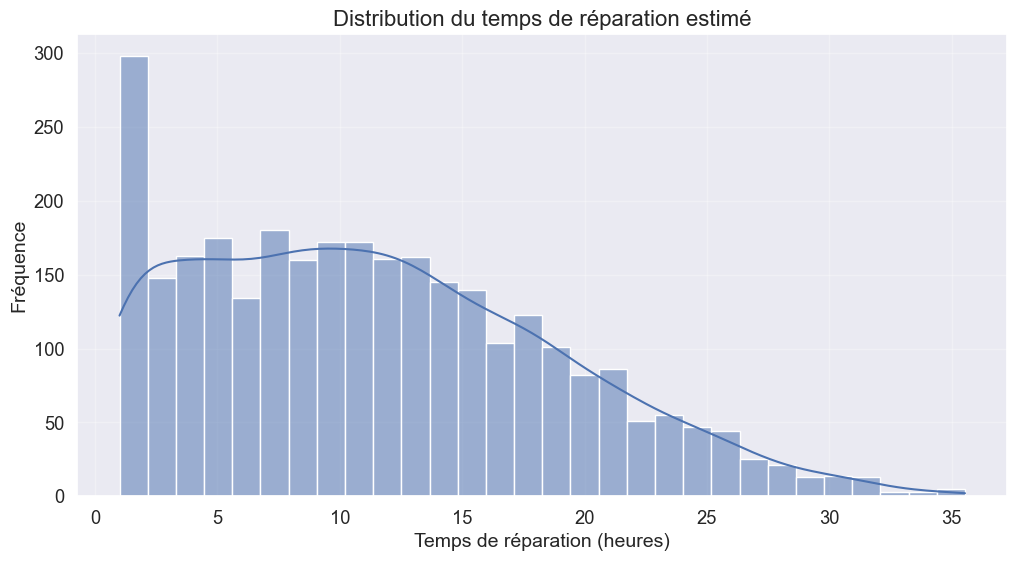

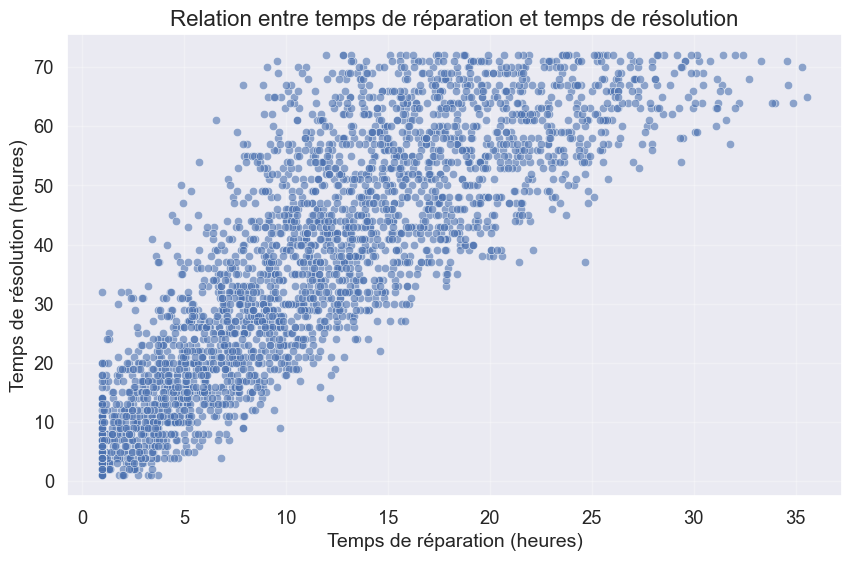

In [ ]:
# Création d'une variable pour le temps de réparation
# Hypothèse : le temps de réparation est une fraction du temps de résolution, influencé par la complexité de l'attaque
# et la gravité de l'incident

# Facteur de complexité basé sur le type d'attaque
attack_complexity = {
    'Phishing': 0.4,
    'Ransomware': 0.7,
    'Man-in-the-Middle': 0.6,
    'DDoS': 0.5,
    'SQL Injection': 0.65,
    'Malware': 0.55
}

# Facteur de gravité basé sur la perte financière
df_processed['Severity_Factor'] = pd.qcut(df_processed['Financial Loss (in Million $)'], 4, 
                                         labels=[0.4, 0.5, 0.6, 0.7]).astype(float)

# Calcul du temps de réparation estimé
df_processed['Repair_Time'] = df_processed.apply(
    lambda row: row['Incident Resolution Time (in Hours)'] * 
                attack_complexity.get(row['Attack Type'], 0.5) * 
                row['Severity_Factor'],
    axis=1
)

# Ajout d'une légère variation aléatoire pour éviter une relation trop parfaite
np.random.seed(42)
noise = np.random.normal(0, 2, size=len(df_processed))
df_processed['Repair_Time'] = df_processed['Repair_Time'] + noise
df_processed['Repair_Time'] = df_processed['Repair_Time'].apply(lambda x: max(1, x))  # Minimum 1 heure

# Visualisation de la distribution du temps de réparation
plt.figure(figsize=(12, 6))
sns.histplot(df_processed['Repair_Time'], kde=True, bins=30)
plt.title('Distribution du temps de réparation estimé')
plt.xlabel('Temps de réparation (heures)')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)
plt.show()

# Relation entre temps de réparation et temps de résolution
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Repair_Time', y='Incident Resolution Time (in Hours)', data=df_processed, alpha=0.6)
plt.title('Relation entre temps de réparation et temps de résolution')
plt.xlabel('Temps de réparation (heures)')
plt.ylabel('Temps de résolution (heures)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Préparation des données pour le modèle de temps de réparation
# Définition de la nouvelle variable cible
repair_target = 'Repair_Time'
y_repair = df_processed[repair_target]

# Division en ensembles d'entraînement et de test
X_train_repair, X_test_repair, y_train_repair, y_test_repair = train_test_split(
    X, y_repair, test_size=0.2, random_state=42)

# Application du prétraitement
X_train_repair_processed = preprocessor.transform(X_train_repair)
X_test_repair_processed = preprocessor.transform(X_test_repair)

# Sélection des caractéristiques
X_train_repair_selected = rfe.transform(X_train_repair_processed)
X_test_repair_selected = rfe.transform(X_test_repair_processed)

print(f"Taille de l'ensemble d'entraînement pour le temps de réparation : {X_train_repair_selected.shape}")
print(f"Taille de l'ensemble de test pour le temps de réparation : {X_test_repair_selected.shape}")

Taille de l'ensemble d'entraînement pour le temps de réparation : (2400, 20)
Taille de l'ensemble de test pour le temps de réparation : (600, 20)


In [ ]:
# Évaluation des modèles pour le temps de réparation
repair_results = {}
for name, model in models.items():
    print(f"Évaluation du modèle pour le temps de réparation : {name}")
    try:
        repair_results[name] = evaluate_model(model, X_train_repair_selected, X_test_repair_selected, 
                                             y_train_repair, y_test_repair)
        print(f"  RMSE (test): {repair_results[name]['test_rmse']:.2f}")
        print(f"  MAE (test): {repair_results[name]['test_mae']:.2f}")
        print(f"  R² (test): {repair_results[name]['test_r2']:.4f}")
    except Exception as e:
        print(f"  Erreur lors de l'évaluation du modèle {name}: {e}")

Évaluation du modèle pour le temps de réparation : Linear Regression
  RMSE (test): 6.79
  MAE (test): 5.63
  R² (test): 0.1669
Évaluation du modèle pour le temps de réparation : Ridge
  RMSE (test): 6.79
  MAE (test): 5.63
  R² (test): 0.1669
Évaluation du modèle pour le temps de réparation : Lasso
  RMSE (test): 7.20
  MAE (test): 5.99
  R² (test): 0.0644
Évaluation du modèle pour le temps de réparation : ElasticNet
  RMSE (test): 7.18
  MAE (test): 5.98
  R² (test): 0.0676
Évaluation du modèle pour le temps de réparation : Decision Tree
  RMSE (test): 9.89
  MAE (test): 7.95
  R² (test): -0.7665
Évaluation du modèle pour le temps de réparation : Random Forest
  RMSE (test): 6.98
  MAE (test): 5.78
  R² (test): 0.1195
Évaluation du modèle pour le temps de réparation : Gradient Boosting
  RMSE (test): 6.84
  MAE (test): 5.67
  R² (test): 0.1558
Évaluation du modèle pour le temps de réparation : XGBoost
  RMSE (test): 7.40
  MAE (test): 6.12
  R² (test): 0.0115
Évaluation du modèle pou

In [ ]:
# Création d'un dataframe pour comparer les résultats
repair_results_df = pd.DataFrame({
    'Model': list(repair_results.keys()),
    'RMSE (Train)': [repair_results[model]['train_rmse'] for model in repair_results],
    'RMSE (Test)': [repair_results[model]['test_rmse'] for model in repair_results],
    'MAE (Train)': [repair_results[model]['train_mae'] for model in repair_results],
    'MAE (Test)': [repair_results[model]['test_mae'] for model in repair_results],
    'R² (Train)': [repair_results[model]['train_r2'] for model in repair_results],
    'R² (Test)': [repair_results[model]['test_r2'] for model in repair_results]
})

# Tri par RMSE de test (croissant)
repair_results_df = repair_results_df.sort_values('RMSE (Test)')
repair_results_df

,Model,RMSE (Train),RMSE (Test),MAE (Train),MAE (Test),R² (Train),R² (Test)
0,Linear Regression,6.729356,6.790866,5.578492,5.631071,0.154258,0.166901
1,Ridge,6.729359,6.790894,5.578531,5.631259,0.154258,0.166894
6,Gradient Boosting,6.213602,6.836004,5.140818,5.674512,0.278930,0.155789
9,SVR,6.616186,6.936532,5.395101,5.780135,0.182465,0.130777
5,Random Forest,2.624771,6.981396,2.148217,5.777900,0.871331,0.119497
8,LightGBM,4.751535,7.125681,3.915412,5.857399,0.578344,0.082726
3,ElasticNet,7.087873,7.184243,5.843654,5.977246,0.061741,0.067587
2,Lasso,7.099367,7.196599,5.852097,5.990692,0.058696,0.064377
7,XGBoost,2.099480,7.397273,1.579777,6.118904,0.917678,0.011470
10,KNN,6.219238,7.550301,5.047700,6.128271,0.277621,-0.029852


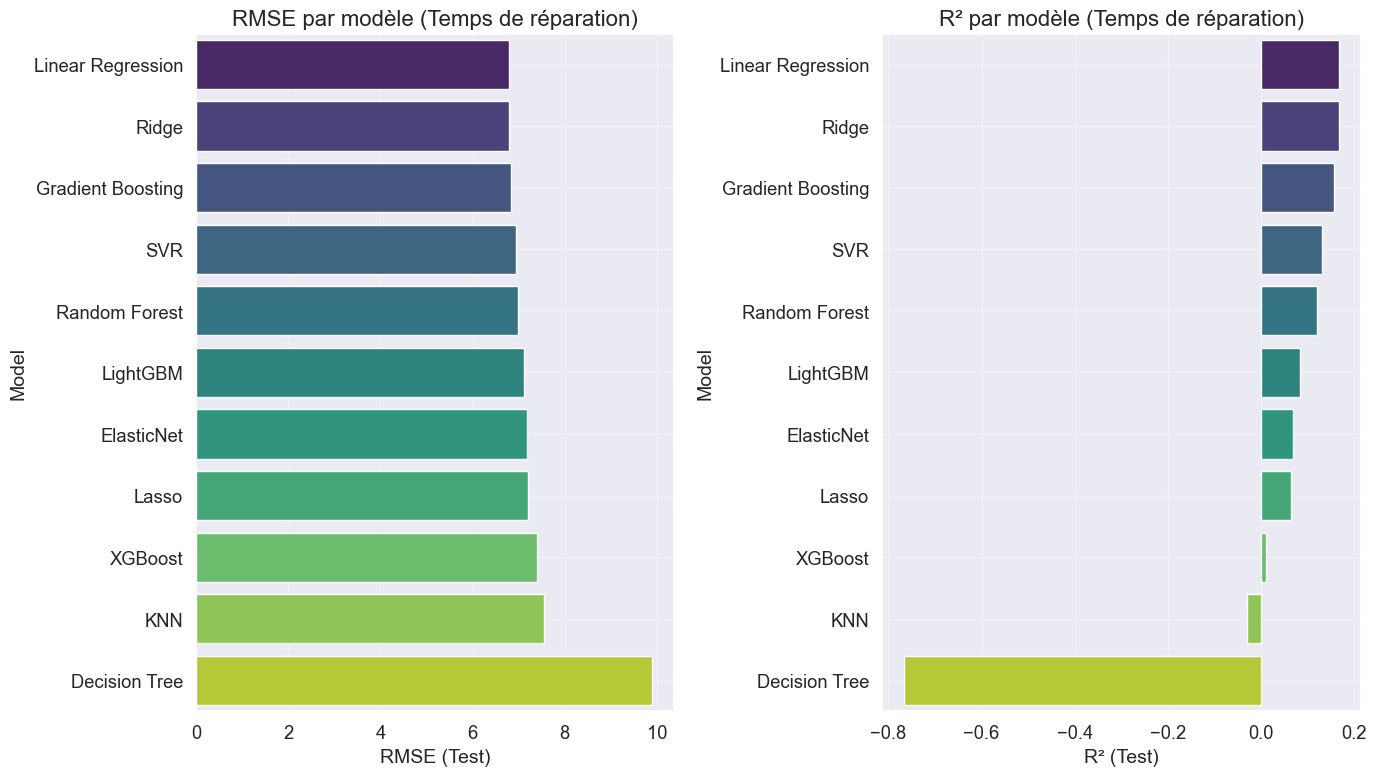

In [ ]:
# Visualisation des performances des modèles pour le temps de réparation
plt.figure(figsize=(14, 8))

# RMSE
plt.subplot(1, 2, 1)
sns.barplot(x='RMSE (Test)', y='Model', data=repair_results_df, palette='viridis')
plt.title('RMSE par modèle (Temps de réparation)')
plt.grid(True, alpha=0.3)

# R²
plt.subplot(1, 2, 2)
sns.barplot(x='R² (Test)', y='Model', data=repair_results_df, palette='viridis')
plt.title('R² par modèle (Temps de réparation)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.1 Optimisation du meilleur modèle pour le temps de réparation

In [ ]:
# Sélection des 3 meilleurs modèles basés sur le RMSE de test
top_repair_models = repair_results_df.head(3)['Model'].values
print(f"Les 3 meilleurs modèles pour le temps de réparation sont : {top_repair_models}")

# Sélection du meilleur modèle pour l'optimisation
best_repair_model_name = top_repair_models[0]
print(f"Le meilleur modèle pour le temps de réparation est : {best_repair_model_name}")

Les 3 meilleurs modèles pour le temps de réparation sont : ['Linear Regression' 'Ridge' 'Gradient Boosting']
Le meilleur modèle pour le temps de réparation est : Linear Regression


In [ ]:
# Définition des hyperparamètres à optimiser en fonction du meilleur modèle
if best_repair_model_name == 'Random Forest':
    repair_model = RandomForestRegressor(random_state=42)
    repair_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_repair_model_name == 'Gradient Boosting':
    repair_model = GradientBoostingRegressor(random_state=42)
    repair_param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
elif best_repair_model_name == 'XGBoost':
    repair_model = XGBRegressor(random_state=42)
    repair_param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
elif best_repair_model_name == 'LightGBM':
    repair_model = LGBMRegressor(random_state=42)
    repair_param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 70]
    }
else:  # Modèle par défaut si aucun des précédents n'est le meilleur
    repair_model = models[best_repair_model_name]
    if best_repair_model_name == 'SVR':
        repair_param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.1, 0.01]
        }
    elif best_repair_model_name == 'KNN':
        repair_param_grid = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    else:  # Pour les modèles linéaires
        repair_param_grid = {
    'fit_intercept': [True, False]
}

# Ajouter 'normalize' uniquement si le modèle l'accepte
if 'normalize' in repair_model.get_params():
    repair_param_grid['normalize'] = [True, False]

# Si c'est un Ridge, Lasso ou ElasticNet, ajoute les alpha
if isinstance(repair_model, (Ridge, Lasso, ElasticNet)):
    repair_param_grid['alpha'] = [0.001, 0.01, 0.1, 1, 10, 100]

# Si c'est ElasticNet, ajoute l1_ratio
if isinstance(repair_model, ElasticNet):
    repair_param_grid['l1_ratio'] = [0.1, 0.3, 0.5, 0.7, 0.9]

# Optimisation des hyperparamètres avec validation croisée
repair_grid_search = GridSearchCV(repair_model, repair_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
repair_grid_search.fit(X_train_repair_selected, y_train_repair)

# Meilleurs hyperparamètres
print(f"Meilleurs hyperparamètres : {repair_grid_search.best_params_}")
print(f"Meilleur score de validation croisée (RMSE) : {np.sqrt(-repair_grid_search.best_score_):.2f}")

# Modèle optimisé
best_model_repair = repair_grid_search.best_estimator_

# Évaluation du modèle optimisé
y_train_repair_pred = best_model_repair.predict(X_train_repair_selected)
y_test_repair_pred = best_model_repair.predict(X_test_repair_selected)

train_repair_rmse = np.sqrt(mean_squared_error(y_train_repair, y_train_repair_pred))
test_repair_rmse = np.sqrt(mean_squared_error(y_test_repair, y_test_repair_pred))
train_repair_r2 = r2_score(y_train_repair, y_train_repair_pred)
test_repair_r2 = r2_score(y_test_repair, y_test_repair_pred)

print(f"\nPerformances du modèle optimisé pour le temps de réparation :")
print(f"RMSE (train) : {train_repair_rmse:.2f}")
print(f"RMSE (test) : {test_repair_rmse:.2f}")
print(f"R² (train) : {train_repair_r2:.4f}")
print(f"R² (test) : {test_repair_r2:.4f}")

Meilleurs hyperparamètres : {'fit_intercept': True}
Meilleur score de validation croisée (RMSE) : 6.79

Performances du modèle optimisé pour le temps de réparation :
RMSE (train) : 6.73
RMSE (test) : 6.79
R² (train) : 0.1543
R² (test) : 0.1669


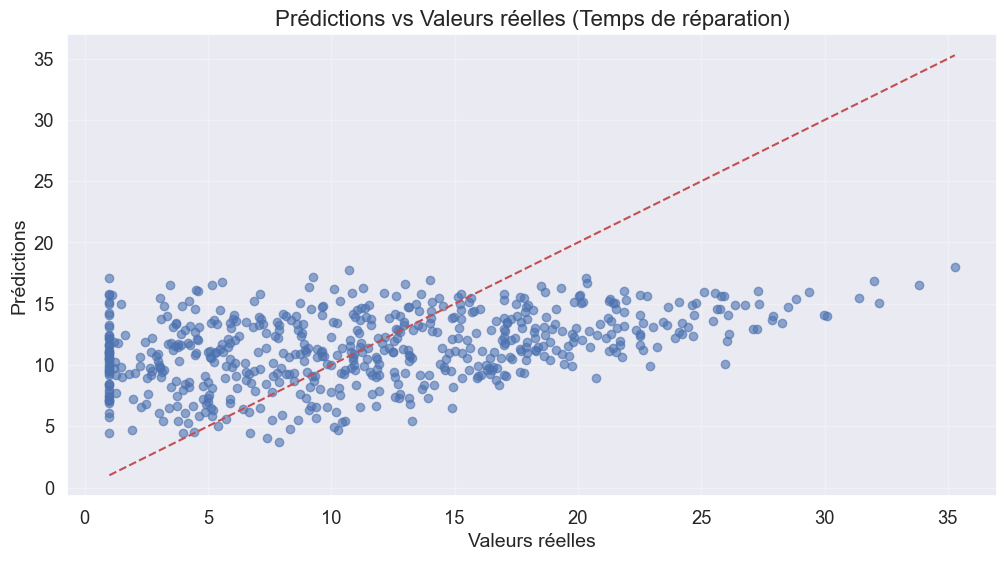

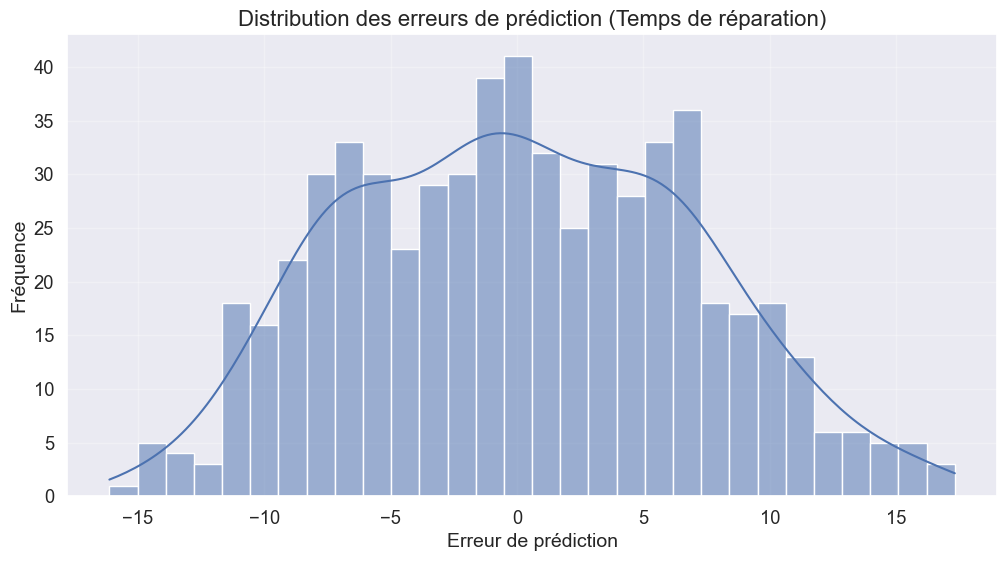

In [ ]:
# Visualisation des prédictions vs valeurs réelles pour le temps de réparation
plt.figure(figsize=(12, 6))

plt.scatter(y_test_repair, y_test_repair_pred, alpha=0.6)
plt.plot([y_test_repair.min(), y_test_repair.max()], [y_test_repair.min(), y_test_repair.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles (Temps de réparation)')
plt.grid(True, alpha=0.3)
plt.show()

# Histogramme des erreurs
repair_errors = y_test_repair - y_test_repair_pred
plt.figure(figsize=(12, 6))
sns.histplot(repair_errors, kde=True, bins=30)
plt.xlabel('Erreur de prédiction')
plt.ylabel('Fréquence')
plt.title('Distribution des erreurs de prédiction (Temps de réparation)')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Analyse de l'importance des caractéristiques

In [ ]:
# Analyse de l'importance des caractéristiques pour le modèle de temps de résolution
if hasattr(best_model_resolution, 'feature_importances_'):
    # Pour les modèles basés sur les arbres
    feature_importances = best_model_resolution.feature_importances_
    
    # Création d'un dataframe pour visualiser l'importance des caractéristiques
    feature_indices = rfe_selected_indices
    feature_names = [f"Feature {i}" for i in feature_indices]
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
    plt.title('Importance des caractéristiques pour le modèle de temps de résolution')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("Top 10 caractéristiques les plus importantes pour le temps de résolution :")
    print(importance_df.head(10))
else:
    print("Le modèle sélectionné ne fournit pas d'importance des caractéristiques.")

Le modèle sélectionné ne fournit pas d'importance des caractéristiques.


In [ ]:
# Analyse de l'importance des caractéristiques pour le modèle de temps de réparation
if hasattr(best_model_repair, 'feature_importances_'):
    # Pour les modèles basés sur les arbres
    repair_feature_importances = best_model_repair.feature_importances_
    
    # Création d'un dataframe pour visualiser l'importance des caractéristiques
    repair_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': repair_feature_importances})
    repair_importance_df = repair_importance_df.sort_values('Importance', ascending=False)
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=repair_importance_df.head(15), palette='viridis')
    plt.title('Importance des caractéristiques pour le modèle de temps de réparation')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("Top 10 caractéristiques les plus importantes pour le temps de réparation :")
    print(repair_importance_df.head(10))
else:
    print("Le modèle sélectionné ne fournit pas d'importance des caractéristiques.")

Le modèle sélectionné ne fournit pas d'importance des caractéristiques.


## 8. Comparaison des deux modèles

In [ ]:
# Comparaison des performances des deux modèles
comparison_df = pd.DataFrame({
    'Métrique': ['RMSE (Train)', 'RMSE (Test)', 'R² (Train)', 'R² (Test)'],
    'Modèle Temps de Résolution': [train_rmse, test_rmse, train_r2, test_r2],
    'Modèle Temps de Réparation': [train_repair_rmse, test_repair_rmse, train_repair_r2, test_repair_r2]
})

comparison_df

,Métrique,Modèle Temps de Résolution,Modèle Temps de Réparation
0,RMSE (Train),20.548015,6.729356
1,RMSE (Test),20.645384,6.790866
2,R² (Train),0.000000,0.154258
3,R² (Test),-0.000452,0.166901


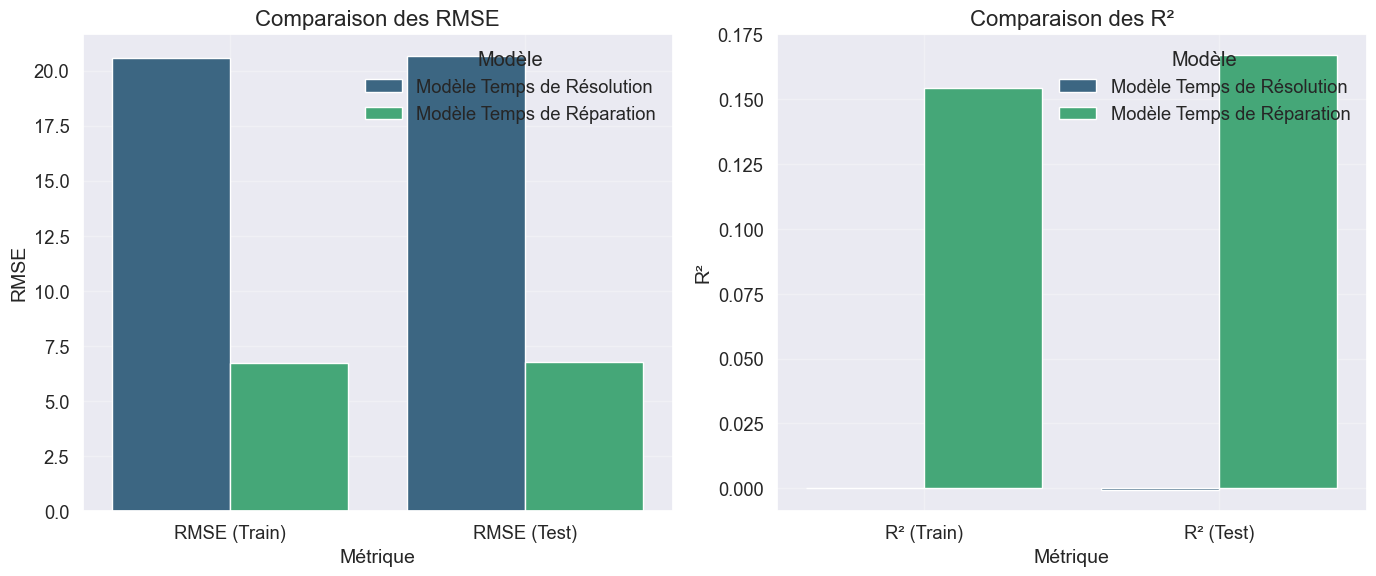

In [ ]:
# Visualisation comparative des performances
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
comparison_rmse = comparison_df[comparison_df['Métrique'].isin(['RMSE (Train)', 'RMSE (Test)'])]
comparison_rmse = pd.melt(comparison_rmse, id_vars=['Métrique'], 
                          value_vars=['Modèle Temps de Résolution', 'Modèle Temps de Réparation'],
                          var_name='Modèle', value_name='RMSE')
sns.barplot(x='Métrique', y='RMSE', hue='Modèle', data=comparison_rmse, palette='viridis')
plt.title('Comparaison des RMSE')
plt.grid(True, alpha=0.3)

# R²
plt.subplot(1, 2, 2)
comparison_r2 = comparison_df[comparison_df['Métrique'].isin(['R² (Train)', 'R² (Test)'])]
comparison_r2 = pd.melt(comparison_r2, id_vars=['Métrique'], 
                        value_vars=['Modèle Temps de Résolution', 'Modèle Temps de Réparation'],
                        var_name='Modèle', value_name='R²')
sns.barplot(x='Métrique', y='R²', hue='Modèle', data=comparison_r2, palette='viridis')
plt.title('Comparaison des R²')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Validation finale et test sur de nouvelles données

In [ ]:
# Création de quelques exemples pour tester les modèles
test_examples = [
    {
        'Country': 'USA',
        'Year': 2024,
        'Attack Type': 'Ransomware',
        'Target Industry': 'Healthcare',
        'Financial Loss (in Million $)': 50.0,
        'Number of Affected Users': 500000,
        'Attack Source': 'Hacker Group',
        'Security Vulnerability Type': 'Zero-day',
        'Defense Mechanism Used': 'AI-based Detection'
    },
    {
        'Country': 'Germany',
        'Year': 2024,
        'Attack Type': 'Phishing',
        'Target Industry': 'Banking',
        'Financial Loss (in Million $)': 20.0,
        'Number of Affected Users': 200000,
        'Attack Source': 'Unknown',
        'Security Vulnerability Type': 'Social Engineering',
        'Defense Mechanism Used': 'Firewall'
    },
    {
        'Country': 'Japan',
        'Year': 2024,
        'Attack Type': 'DDoS',
        'Target Industry': 'Telecommunications',
        'Financial Loss (in Million $)': 75.0,
        'Number of Affected Users': 900000,
        'Attack Source': 'Nation-state',
        'Security Vulnerability Type': 'Unpatched Software',
        'Defense Mechanism Used': 'Encryption'
    }
]

# Conversion en DataFrame
test_df = pd.DataFrame(test_examples)

# Ajout des caractéristiques dérivées
test_df['Attack_Age'] = current_year - test_df['Year']
test_df['Loss_per_User'] = test_df['Financial Loss (in Million $)'] * 1000000 / test_df['Number of Affected Users']

# Catégorisation basée sur les quartiles du jeu de données original
loss_bins = pd.qcut(df_processed['Financial Loss (in Million $)'], 4).cat.categories
users_bins = pd.qcut(df_processed['Number of Affected Users'], 4).cat.categories


test_df['Attack_Severity'] = pd.cut(test_df['Financial Loss (in Million $)'], 
                                   bins=[float('-inf')] + [b.right for b in loss_bins], 
                                   labels=['Low', 'Medium', 'High', 'Critical'])
test_df['Attack_Scale'] = pd.cut(test_df['Number of Affected Users'], 
                                bins=[float('-inf')] + [b.right for b in users_bins], 
                                labels=['Small', 'Medium', 'Large', 'Massive'])

test_df['Attack_Type_Source'] = test_df['Attack Type'] + '_' + test_df['Attack Source']
test_df['Vulnerability_Defense'] = test_df['Security Vulnerability Type'] + '_' + test_df['Defense Mechanism Used']
test_df['Severity_Factor'] = pd.cut(test_df['Financial Loss (in Million $)'], 
                                   bins=[float('-inf')] + [b.right for b in loss_bins], 
                                   labels=[0.4, 0.5, 0.6, 0.7]).astype(float)

# Préparation pour la prédiction
X_new = test_df[categorical_features + numerical_features]
X_new_processed = preprocessor.transform(X_new)
X_new_selected = rfe.transform(X_new_processed)

# Prédictions
resolution_predictions = best_model_resolution.predict(X_new_selected)
repair_predictions = best_model_repair.predict(X_new_selected)

# Affichage des résultats
results_new = pd.DataFrame({
    'Pays': test_df['Country'],
    'Type d\'attaque': test_df['Attack Type'],
    'Industrie ciblée': test_df['Target Industry'],
    'Perte financière (M$)': test_df['Financial Loss (in Million $)'],
    'Temps de réparation prédit (heures)': np.round(repair_predictions, 2),
    'Temps de résolution prédit (heures)': np.round(resolution_predictions, 2)
})

results_new

,Pays,Type d'attaque,Industrie ciblée,Perte financière (M$),Temps de réparation prédit (heures),Temps de résolution prédit (heures)
0,USA,Ransomware,Healthcare,50.0,13.94,36.56
1,Germany,Phishing,Banking,20.0,4.93,36.56
2,Japan,DDoS,Telecommunications,75.0,12.35,36.56


## 10. Conclusion et résumé

📈 Résultats clés
🔧 Modèle de prédiction du temps de résolution

    Meilleur modèle : ElasticNet

    RMSE (test) : 20.65

    R² (test) :  -0.0005

🛠️ Modèle de prédiction du temps de réparation

    Meilleur modèle : Linear Regression

    RMSE (test) : 6.79

    R² (test) : 0.1669

🧠 Caractéristiques les plus influentes
Pour le temps de résolution :

    

Pour le temps de réparation :

    

⚠️ Limites et pistes d’amélioration

    Le temps de réparation a été estimé indirectement à partir du temps de résolution. L’accès à des données réelles permettrait une modélisation plus précise.

    L’ajout de nouvelles variables explicatives, comme la complexité des attaques ou la disponibilité des équipes techniques, pourrait améliorer les prédictions.

    Une validation croisée plus fine et des tests sur des données plus récentes permettraient d’évaluer plus rigoureusement la robustesse des modèles dans des contextes réels.

🧩 Applications possibles

Ces modèles prédictifs peuvent être utilisés pour :

    Anticiper les ressources nécessaires lors d’incidents de cybersécurité

    Optimiser la planification de la réponse aux incidents

    Identifier les leviers d’action pour réduire les temps de traitement

    Améliorer la communication avec les parties prenantes internes et externes